# An RNN Sequence tagger for annotation of ECGs

This example shows how to set-up a sequence tagger and how to integrate self-written
recurrent units with the NNHelferlein ecosystem.

The goal is, to annotate ECG recordings with the heart beats. 
As training data, a reduced set of 18 long-term ECG recordings have been prepared form the Physionet-Database
(MIT-BIH Normal Sinus Rhythm Database, doi: https://doi.org/10.13026/C2NK5R).

The ECGs are provided with a sampling rate of 128 points per sec and short windows are sampled 
from the data for training.
To include about two heart beats in each window, sequences of 200 time steps are generated. 
To be able to handle these long sequences, we use Peephole-LSTM units which are said 
to be a good choice for long sequences with rare peaks.

In [1]:
using Knet: param, param0, sigm, Adam
using NNHelferlein
using CSV, DataFrames, Statistics
using Plots
using ImageFiltering

In [2]:
WIN = 200             # window size in time steps (rate = 128 per sec)
SMOOTH = 11           # window size of kernel smoothing
UNITS = 8             # number of recurrent units
MB = 512              # minibatch size
TRN = 1:15            # ECGs for training
TST = 16:18           # ECGs for test
NAME="Beat-finder-$UNITS"    # name for TensorBoard log

"Beat-finder-8"

## Dataset:
The 18 data files are provided as part of the NNhelferlein distribution as csv-files 
16265, 16272, 16273, 16420, 16483, 16539, 16773, 16786, 16795,
17052, 17453, 18177, 18184, 19088, 19090, 19093, 19140, 19830.
The files comprise the 3 columns `normal heart beat 0/1`, `channel 1` 
and `channel 2` of the ECG.
Each file includes apount 50 000 heart beats and 15 of the files are used for training and validation
and 3 for testing.

To make the classification task a little bit less unbalanced the *beat* column (that displays
many zeros and only single ones to mark the heart beats) is replaced by a 
*smooth* column by applying a gaussian filter to the beats. The shape of this new 
teaching input (or training target) is shown as green line in the first plot 
(in the later plots, the green line shows the prediction!).

The importer function reads the training files and samples randomly windows of length 200 from the 
ECGs. The number of windows is adjusted, so that the total number of steps in all windows equals the
total number of time steps in the source file (in analogy to a 0.632 bootstrap).

In [3]:
nsr = dataset_mit_nsr(;force=true)
nsr[2][1:3,:]

  downloading 1 of 18: 16265.ecg.gz
  downloading 2 of 18: 16272.ecg.gz
  downloading 3 of 18: 16273.ecg.gz
  downloading 4 of 18: 16420.ecg.gz
  downloading 5 of 18: 16483.ecg.gz
  downloading 6 of 18: 16539.ecg.gz
  downloading 7 of 18: 16773.ecg.gz
  downloading 8 of 18: 16786.ecg.gz
  downloading 9 of 18: 16795.ecg.gz
  downloading 10 of 18: 17052.ecg.gz
  downloading 11 of 18: 17453.ecg.gz
  downloading 12 of 18: 18177.ecg.gz
  downloading 13 of 18: 18184.ecg.gz
  downloading 14 of 18: 19088.ecg.gz
  downloading 15 of 18: 19090.ecg.gz
  downloading 16 of 18: 19093.ecg.gz
  downloading 17 of 18: 19140.ecg.gz
  downloading 18 of 18: 19830.ecg.gz


,time,channel_1,channel_2,beat,smooth
,Float64,Float32,Float32,Float32,Float32
1,0.0078125,-0.032,-0.0541,0.0,0.0
2,0.015625,-0.032,0.0582,0.0,0.0
3,0.0234375,-0.032,0.0582,0.0,0.0


#### Plotting the ECGs:

In [4]:
function plotWindow(t, ch1, ch2, beats, preds=nothing)
    
    plt = plot(t, ch1, ylim=(-3.1,3), color=:black, 
               yticks=false, legends=false)
    plt = plot(plt, t, ch2.+2, color=:blue)
    plt = plot(plt, t, beats.-2, color=:red)
    if !isnothing(preds)
        preds = Array(preds)
        plt = plot(plt, t, preds.-3, color=:green)
    end
    display(plt)
    return plt
end

function plotECG(x, start; win=1000)
    range = start:start+win
    if "smooth" in names(x)
        p = x.smooth[range]
    else
        p = nothing
    end
    plotWindow(x.time[range], x.channel_1[range], x.channel_2[range], x.beat[range], p)
end

plotECG (generic function with 1 method)

Plot illustrating the training data:
+ *black, blue:* channel 1 and 2 of the ecg, scaled to a range
  from-1 to 1
+ *red:* annotated heart beats; only one time step marks the exact 
  position of the beats
+ *green:* smoothed beats as teaching input.

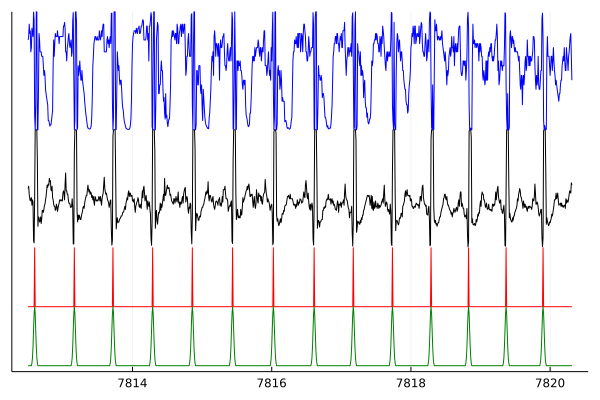

In [5]:
plotECG(nsr[1], 1000000);

<!-- <img src="assets/62-data.png"> -->

#### Window sampling:

Minibaches are constructed from randomly sampled windows from the training data:

In [6]:
function random_window_sample(df...; win=200, n=nothing)
    x = []; y = []
    
    num_df = length(df)
    total = reduce(+, nrow.(df))
    if isnothing(n)
        n = cld(total, win)
    end
    println("Sampling $n windows from $num_df ECGs")

    for i in 1:n
        dfs = df[rand(1:num_df)]
        rows = nrow(dfs)
    
        wstart = rand(1:rows-win+1)
        wrange = wstart:wstart+win-1
        push!(x, permutedims(Array(dfs[wrange,[:channel_1, :channel_2]]), (2,1)))
        push!(y, Array(dfs[wrange,:smooth]))
    end
    return (x, y)
end

random_window_sample (generic function with 1 method)

In [7]:
x,y = random_window_sample(nsr[TRN]..., win=WIN);

Sampling 369801 windows from 15 ECGs


In [8]:
dtrn = sequence_minibatch(x,y, MB, seq2seq=false);

In [9]:
x,y = first(dtrn)

([-0.3195 -0.3667 … -0.0631 -0.1162; -0.4083 -0.4083 … -0.2664 -0.2664;;; -0.2701 -0.2701 … -0.3068 -0.2886; -0.5121 -0.5121 … -0.3035 -0.3318;;; -0.3706 -0.4675 … 0.988 -0.9904; -0.6719 0.1458 … -0.9999 -0.9999;;; … ;;; -0.032 0.0891 … -0.101 -0.101; 0.7172 0.4235 … 0.2232 0.2232;;; -0.6082 -0.5734 … -0.0631 -0.2706; 0.048 0.048 … -0.1904 -0.4083;;; -0.678 -0.7402 … -0.4205 -0.4205; -0.4343 -0.5305 … -0.088 -0.2107], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

## Peephole LSTM

The peephole LSTM unis are defined as a subtype of `RecurrentUnit` with a signature for
forward calculation of one minibatch.
Design follows the original paper of Gers & Schmidhuber 
*(Learning Precise Timing with LSTM Recurrent Networks, 
Journal of Machine Learning Research 3 (2002) 115-143):*

In the formulas, $x$ denotes the layer input and 
$h_{t-1}$ the recurrent connections; i.e. the hidden state of
the last step.   
$g$ denotes any of the gate openings $g_i, g_o, g_f$.

#### Input, output and forget gates:
In addtion to the vanilla LSTM gate function, the current cell state $c_{t-1}$,
multiplied with a trainable weight $c_g$, is taken into account here
(for a single unit, $c_g$ and $c$ are scalars; to calculate gates for 
a complete layer, the respective vectors has the length of the number of units
and must be multiplicated element-wise, denoted as $\odot$):

$$ g_{g\in(i,o,f)} = \sigma(W_g \cdot [h_{t-1}, x_t] + b_g + c_{g} \odot c_{t-1})$$

#### Cell state:
The cell state is updated the same way as in normal LSTM units, by a 
*tanh*-activated layer weighted by the input gate plus the forget gate 
influence:

$$ c_t = g_{forget} \odot c_{t-1} + g_{input} \odot \tanh(W_i \cdot [h_{t-1}, x_t] + b_i) $$ 

#### Hidden state (output):
The next hidden state is calculated by multiplying *tanh* of the cell state 
with the output gate:

$$ h_t = \tanh(c_t) \odot g_o $$

The following implementation is not optimised for performance but it 
follows strictly these formulas for clearness:

In [10]:
mutable struct Peep <: RecurrentUnit
    w; w_r; b            # input
    w_i; w_ir; c_i; b_i  # input gate
    w_o; w_or; c_o; b_o  # output gate
    w_f; w_fr; c_f; b_f  # forget gate
    c                    # cell state
    h                    # last hidden state

    function Peep(i, n; o...)   # i: fan-in, n: num cells
        w = param(n, i);    w_r = param(n, n); b = param0(n)
        w_i = param(n, i); w_ir = param(n, n); c_i = param0(n); b_i = param0(n)
        w_o = param(n, i); w_or = param(n, n); c_o = param0(n); b_o = param0(n)
        w_f = param(n, i); w_fr = param(n, n); c_f = param0(n); b_f = param(n, init=ones)
        c = init0(n)
        h = init0(n)

        new(w, w_r, b, 
             w_i, w_ir, c_i, b_i, 
             w_o, w_or, c_o, b_o, 
             w_f, w_fr, c_f, b_f, 
             c, h)
    end
end

In [11]:
function (l::Peep)(x)
    
    # gates:
    #
    i_gate = sigm.(l.w_i * x .+ l.w_ir * l.h .+ l.c_i .* l.c .* l.b_i)
    o_gate = sigm.(l.w_o * x .+ l.w_or * l.h .+ l.c_o .* l.c .* l.b_o)
    f_gate = sigm.(l.w_f * x .+ l.w_fr * l.h .+ l.c_f .* l.c .* l.b_f)
    
    # cell state:
    #
    c_temp = tanh.(l.w * x .+ l.w_r * l.h .+ l.b)     
    l.c = c_temp .* i_gate .+ l.c .* f_gate
    
    # hidden state (output):
    #
    l.h = tanh.(l.c) .* o_gate
    return l.h
end

## The model:

The ECG annotator model is defined as a RNN sequence tagger of one bidirectional layer
of the self-defined peephole LSTM units and a fully connected layer to predict
the state for each time step (beat or no beat).

The square loss is modified to increase the weight of false negative predictions,
because the training data includes much more non-beats as beats.

A thin network of only 8 peephole-LSTM units might be already able to solve the problem:

In [12]:
mutable struct BeatFinder <: DNN
    rlayer    # recurrent layer
    predict   # dense layer to generate 1/0 prediction
    n_units
    
    function BeatFinder(inputs, n_units)
        return new(Recurrent(inputs, n_units, u_type=Peep, bidirectional=true),
                   Linear(2*n_units, 1),
                   n_units)
    end
end

In [13]:
function (bf::BeatFinder)(x)
    x = bf.rlayer(x, return_all=true, h=0, c=0)
    x = bf.predict(x)
    x = reshape(x, size(x, 2),:)
    return x
end

function (bf::BeatFinder)(x,y)
    p = bf(x)
    weights = y .+ 1
    loss = mean(abs2, (p .- y) .* weights) # increase weight of peaks!
    return loss
end

In [14]:
bf = BeatFinder(2, 8)

BeatFinder(Recurrent(2, 8, Peep, Peep(P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,2)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,2)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,2)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,2)), P(CUDA.CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(8,8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), P(CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}(8)), Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Peep(P(CUDA.CuArray{Fl

In [15]:
print_network(bf)

NNHelferlein neural network summary:
BeatFinder,                                                        769 params
Details:
 
    Bidirectional Recurrent layer, 2 → 8 of type Peep,             752 params
    Linear layer 16 → 1, with identity,                             17 params
 
Total number of layers: 2
Total number of parameters: 769


2

# Training

As we have almost half a million windows in the training set, only one epoch is trained
after splitting 10% of the data for validation.    
Of course, LSTMs are slow - one epoch needs about 10 minutes (accuracy calculation for the 
full dataset takes almost the same time again):

In [16]:
bf = tb_train!(bf, Adam, dtrn, epochs=1, split=0.9, eval_freq=2, 
               acc_fun=peak_finder_acc, tb_name="$NAME");

Splitting dataset for training (90%) and validation (10%).
Training 1 epochs with 650 minibatches/epoch and 72 validation mbs.
Evaluation is performed every 325 minibatches with 15 mbs.
Watch the progress with TensorBoard at:
/home/andreas/Documents/Projekte/2022-NNHelferlein_KnetML/NNHelferlein/examples/logs/Beat-finder-8/2022-11-10T15-46-24


Progress: 100%|█████████████████████████████████████████| Time: 0:07:02


Training finished with:
Training loss:       0.013556636
Training accuracy:   0.9861482579671199
Validation loss:     0.013593569
Validation accuracy: 0.9860763340963535


# Validation

The quite narrow rnn reliably detects heartbeats in ECGs of reasonably good quality with F1-Score 
between 98% and 99% for training and validation data.
Errors only occur when the series is disturbed or at the very edge of windows.

Visual validation is possible with the `plot_test()` function, which 
plots a window of an ECG dataset together with the true heart beats (in *red*) and
the predictions (in *green*).

In [17]:
function window_split(df; win=200)
    x = []
    y = []
    i = 1
    while i <= nrow(df) - win+1
        wrange = i:i+win-1
        push!(x, permutedims(Array(df[wrange,[:channel_1, :channel_2]]), (2,1)))
        push!(y, Array(df[wrange,:beat]))
        i += win
    end
        
    return (x, y)
end

window_split (generic function with 1 method)

In [18]:
function plot_test(ecg; sec=0.0, steps=2000, win=200)
    i_start = Int(ceil(sec * 128)) + 1
    i_end = i_start + 129*200
    x,y = window_split(ecg[i_start:i_end,:], win=win)
    dtst = sequence_minibatch(x,y, 128, seq2seq=false, shuffle=false, partial=false)
    x,y = first(dtst)
    p = reshape(bf(x), :,1)[1:steps]

    df = ecg[i_start:i_start+steps-1,:]
    plotWindow(df.time, df.channel_1, df.channel_2, df.beat, p)
    peak_finder_acc(p, df.beat, verbose=3)
end

plot_test (generic function with 1 method)

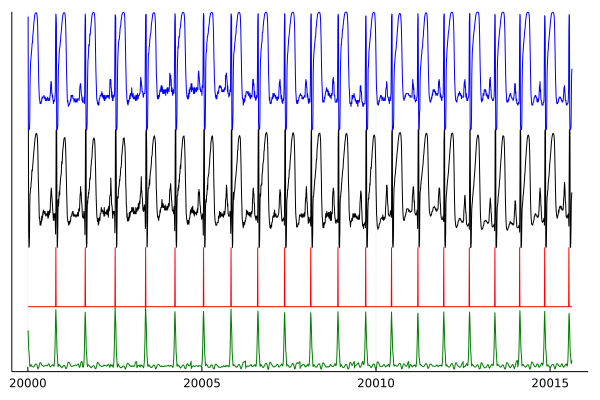

Number of Peaks: 20
Predicted Peaks: 20
True Positives:  20
False Positives: 0
False Negatives: 0
Recall (TPR):    1.0
Precision (PPV): 1.0
Miss Rate (FNR): 0.0
F1-Score:        1.0
G-Mean:          1.0
I over U:        1.0


1.0

In [19]:
plot_test(nsr[16], sec=20000)

<!-- <img src="assets/62-vali-16.png"> -->

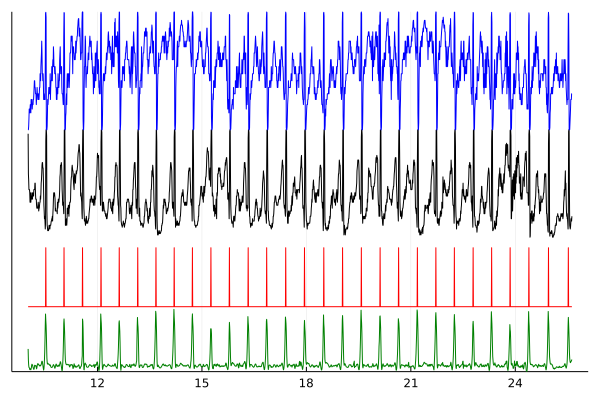

Number of Peaks: 29
Predicted Peaks: 29
True Positives:  29
False Positives: 0
False Negatives: 0
Recall (TPR):    1.0
Precision (PPV): 1.0
Miss Rate (FNR): 0.0
F1-Score:        1.0
G-Mean:          1.0
I over U:        1.0


1.0

In [20]:
plot_test(nsr[18], sec=10)

<!-- <img src="assets/62-vali-18.png"> -->